# Homework 1

## Problem 1: Mortality Prediction in the ICU

In [1]:
# Load the GOSSIS dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("modified_gossis.csv")

(a) Data leakage

In [2]:
# category 1
features_not_predictive = ["encounter_id", "patient_id", "hospital_id", "icu_id"]

# category 2
features_to_remove = ["elective_surgery",
                    "albumin_apache", "apache_2_diagnosis",
                    "apache_3j_diagnosis", "apache_post_operative",
                    "arf_apache", "bilirubin_apache", "bun_apache",
                    "creatinine_apache", "fio2_apache", "gcs_eyes_apache",
                    "gcs_motor_apache", "gcs_unable_apache",
                    "gcs_verbal_apache", "glucose_apache",
                    "heart_rate_apache", "hematocrit_apache",
                    "intubated_apache", "map_apache", "paco2_apache",
                    "paco2_for_ph_apache", "pao2_apache", "ph_apache",
                    "resprate_apache", "sodium_apache", "temp_apache",
                    "urineoutput_apache", "ventilated_apache",
                    "wbc_apache", "apache_4a_hospital_death_prob",
                    "apache_4a_icu_death_prob", "apache_3j_bodysystem",
                    "apache_2_bodysystem", "Medication name",
                    "Medication Dosage", "Complete medication name",
                    "Blood culture", "Urine culture", "Sputum culture",
                    "Serum immunoglobulins (IgA) (mg/dl)",
                    "Serum immunoglobulins (IgG) (mg/dl)",
                    "Serum immunoglobulins (IgM) (mg/dl)",
                    "ANCA (AU/mL)",
                    "Serum complement (total) (C3) (mg/dl)",
                    "Serum complement (total) (C4) (mg/dl)"]
# category 3 (the rest)

# features to drop is category 1 & category 2
features_to_drop = features_not_predictive + features_to_remove
# and the outcome:
label = "hospital_death"

(b) Run the cell below to build your dataset and standardize it.

In [3]:
# Define the dataset and the target variable

X = df.drop(columns=features_to_drop+[label])
y = df[[label]]
# transform categorical features into string type
# (to apply a specific preprocessing pipeline to those features later)
columns_force_categorical = ["readmission_status", "aids",
                             "cirrhosis", "diabetes_mellitus",
                             "hepatic_failure", "immunosuppression",
                             "leukemia", "lymphoma",
                             "solid_tumor_with_metastasis"]
for c in columns_force_categorical:
    X[c] = X[c].fillna(-1)
    X[c] = X[c].astype(int)
    X[c] = X[c].astype(str)
    X[c] = X[c].replace("-1", np.nan)

In [4]:
# Preprocessing pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Simple Imputer with the mean & Standard Scaler for numerical features
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)
# OneHotEncoder for categorical features
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    transformers=[
        (
            "num",
            numeric_transformer,
            selector(dtype_exclude=["category", object, "string"]),
        ),
        (
            "cat",
            categorical_transformer,
            selector(dtype_include=["category", object, "string"]),
        ),
    ]
)

preprocessing_pipeline = Pipeline(
    steps=[("preprocessing", preprocessing)]
)

In [5]:
# Split the dataset (20% in test set)
from sklearn.model_selection import train_test_split

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [6]:
# Train the preprocessing pipeline on the train set and apply it on the test set

X_train = preprocessing_pipeline.fit_transform(X_train_raw)  # fit on train set
# extract new feature names
features_names = list(preprocessing_pipeline[0].transformers_[0][2]) + list(preprocessing_pipeline[0].transformers_[1][1].get_feature_names_out())
X_train = pd.DataFrame(X_train, columns=features_names)  # to dataframe type
# apply preprocessing pipeline to test set
X_test = pd.DataFrame(preprocessing_pipeline.transform(X_test_raw), columns=features_names)

(c) Train a logistic regression model to predict mortality based on the standardized features.

Compute and report the following performance metrics in a table on each of the train and
test sets:

- Accuracy

- Precision

- Recall

- F1-score

- AUC score

In [7]:
# fit the model
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

c:\Users\acarr\miniconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\acarr\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [73]:
# Evaluate a model on train and test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from collections import defaultdict


metrics_dic = {"Accuracy": accuracy_score,
               "Precision": precision_score,
               "Recall": recall_score,
               "F1-score": f1_score,
               "AUC Score": roc_auc_score}


def evaluate_model(model, metrics_dic, X_train, y_train, X_test, y_test, sample_weight=None):
    metrics = defaultdict(list)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    for metric_name, metric_fun in metrics_dic.items():
        metrics[metric_name].append(metric_fun(y_train, pred_train, sample_weight=sample_weight))
        metrics[metric_name].append(metric_fun(y_test, pred_test))

    metrics["Dataset"] = ["Train", "Test"]
    # Result as a dataframe
    res = pd.DataFrame()
    for key in list(metrics.keys()):
        res[key] = metrics[key]
    res.set_index("Dataset", inplace=True)
    return res

In [9]:
lr_metrics = evaluate_model(lr, metrics_dic, X_train, y_train, X_test, y_test)

(d) Repeat part (c) using a bagging random forest classifier (from scikit-learn) and using a gradient-boosted random forest classifier (from the xgboost library).

In [10]:
# fit the model
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

c:\Users\acarr\miniconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForestClassifier(random_state=42)

In [11]:
import xgboost

xgb = xgboost.XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [12]:
rf_metrics = evaluate_model(rf, metrics_dic, X_train, y_train, X_test, y_test)

In [13]:
xgb_metrics = evaluate_model(xgb, metrics_dic, X_train, y_train, X_test, y_test)

(e) Plot two histograms (one for the train set, on for the test set) of the performance metrics you just obtained. Plot the name of each metric along the x-axis, and color-code the bars based on their corresponding model.

In [14]:
import plotly.graph_objects as go


all_metrics_values = {"Logistic Regression": lr_metrics,
                      "Random Forest": rf_metrics,
                      "XGBoost": xgb_metrics}


def plot_bar_results(dataset_type, all_metrics_values):
    fig = go.Figure()
    for model_name, metrics_df in all_metrics_values.items():
        metrics_names = list(metrics_df.columns)
        values = metrics_df.loc[dataset_type].to_numpy()
        fig.add_trace(go.Bar(y=values, x=metrics_names, name=model_name))

    fig.update_layout(barmode="group", xaxis_tickangle=-45, title_text=dataset_type+" Dataset")
    fig.show()

In [15]:
plot_bar_results("Train", all_metrics_values)

In [16]:
plot_bar_results("Test", all_metrics_values)

(f) Which model has the best performance? Briefly explain your answer

XGBoost seems to perform better. On the train set, the performances are lower than the Random Forest which clearly overfit. On the test set, XGBoost has the higher accuracy, F1-score an AUC Score, which means that this model seems to generalize more.

(g) Use the shap library to compute and plot the Shapley values of the xgboost model’s
features on a beeswarm plot. Which features contribute the most to the model’s predictions?
Do they seem like reasonable features that the model can rely on, or is the model basing its
predictions on spurious correlations?

In [17]:
!pip install shap

c:\Users\acarr\miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


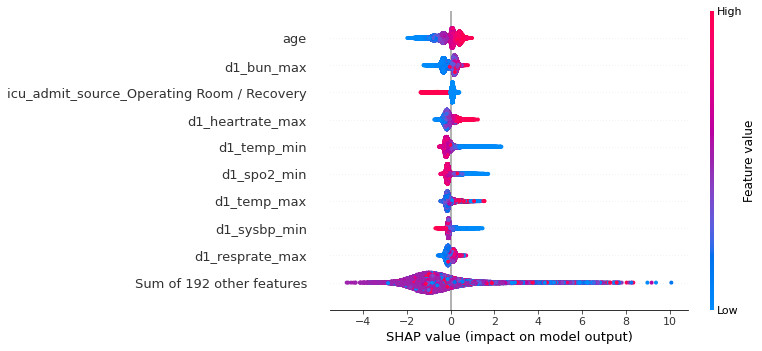

In [18]:
import shap

explainer = shap.Explainer(xgb)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values)

Most predictive features are:

- age

- d1_bun_max

- icu_admit_source

- d1_heartrate_max

It seems reasonable.

(h) Follow the instructions in the notebook to split the test set into cohorts in three different ways.

In [47]:
def calculate_cohorts(X_test, X_test_raw):
    white_X, non_white_X = X_test[X_test["ethnicity_Caucasian"] == 1], X_test[X_test["ethnicity_Caucasian"] != 1]
    male_X, female_X = X_test[X_test["gender_M"] == 1], X_test[X_test["gender_F"] == 1]
    younger_X, older_X = X_test[(X_test_raw["age"].fillna(X_test_raw["age"].mean()) < 65).to_numpy()], X_test[(X_test_raw["age"].fillna(X_test_raw["age"].mean()) >= 65).to_numpy()]
    return white_X, non_white_X, male_X, female_X, younger_X, older_X

In [20]:
# X
white_X, non_white_X, male_X, female_X, younger_X, older_X = (X_test, X_test_raw)
# y
white_y, non_white_y = y_test[(X_test["ethnicity_Caucasian"] == 1).to_numpy()], y_test[(X_test["ethnicity_Caucasian"] != 1).to_numpy()]
male_y, female_y = y_test[(X_test["gender_M"] == 1).to_numpy()], y_test[(X_test["gender_F"] == 1).to_numpy()]
younger_y, older_y = y_test[(X_test_raw["age"].fillna(X_test_raw["age"].mean()) < 65).to_numpy()], y_test[(X_test_raw["age"].fillna(X_test_raw["age"].mean()) >= 65).to_numpy()]

(i) Compute the same performance metrics (accuracy, precision, recall, F1 score and AUC score) for the xgboost model on each test cohort separately. Similarly to part (e), plot these metrics on a single histogram for each split (metric names along the x-axis, metric values along the y-axis, and color-coded by cohort split).

In [21]:
white_metrics = evaluate_model(xgb, metrics_dic, X_train, y_train, white_X, white_y)
non_white_metrics = evaluate_model(xgb, metrics_dic, X_train, y_train, non_white_X, non_white_y)
male_metrics = evaluate_model(xgb, metrics_dic, X_train, y_train, male_X, male_y)
female_metrics = evaluate_model(xgb, metrics_dic, X_train, y_train, female_X, female_y)
younger_metrics = evaluate_model(xgb, metrics_dic, X_train, y_train, younger_X, younger_y)
older_metrics = evaluate_model(xgb, metrics_dic, X_train, y_train, older_X, older_y)

metrics_ethnicity = {"White": white_metrics,
                     "Non white": non_white_metrics}
metrics_gender = {"Male": male_metrics,
                  "Female": female_metrics}
metrics_age = {"Younger": younger_metrics,
               "Older": older_metrics}

In [22]:
plot_bar_results("Test", metrics_ethnicity)

In [23]:
plot_bar_results("Test", metrics_gender)

In [24]:
plot_bar_results("Test", metrics_age)

The model seems to perform equally in each cohort and in each split.

(k) For each of the above three splits, select two data points from each cohort and visualize the Shapley values of each data point on a waterfall plot using the shap library. Include the plots in your report.

In [25]:
# Visualize an explanation for the first prediction of each cohort/split using a waterfall plot

shap_white = explainer(white_X[:1])[0]
shap_non_white = explainer(non_white_X[:1])[0]
shap_male = explainer(male_X[:1])[0]
shap_female = explainer(female_X[:1])[0]
shap_younger = explainer(younger_X[:1])[0]
shap_older = explainer(older_X[:1])[0]

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


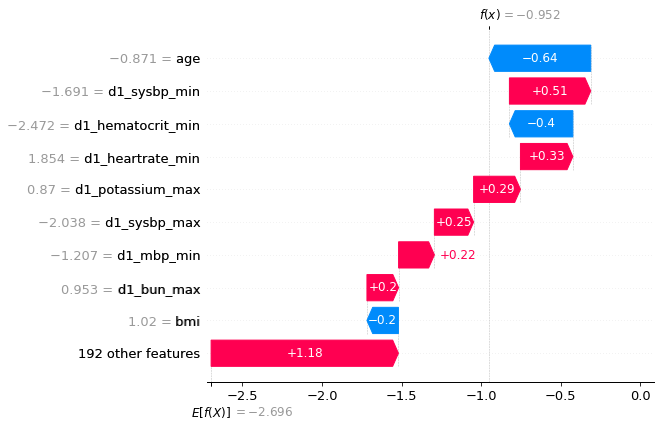

In [26]:
shap.plots.waterfall(shap_white)

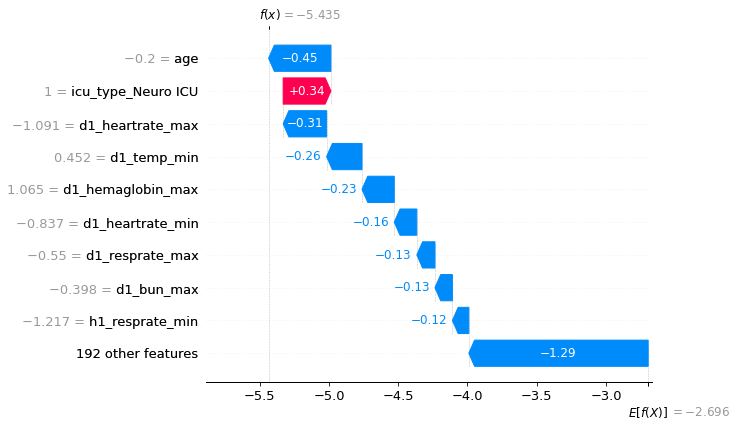

In [27]:
shap.plots.waterfall(shap_non_white)

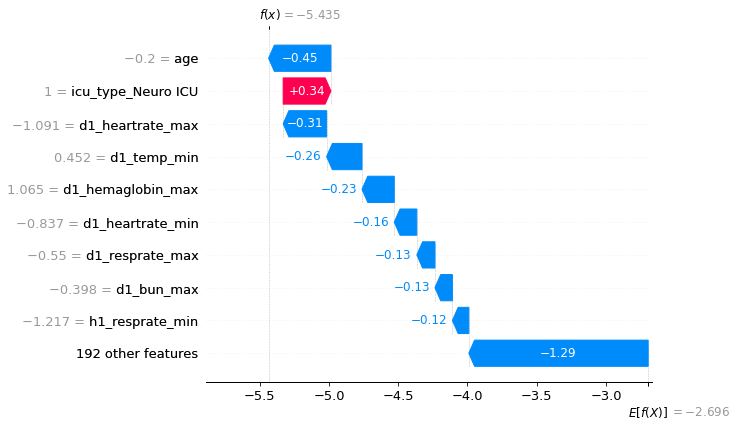

In [ ]:
shap.plots.waterfall(shap_male)

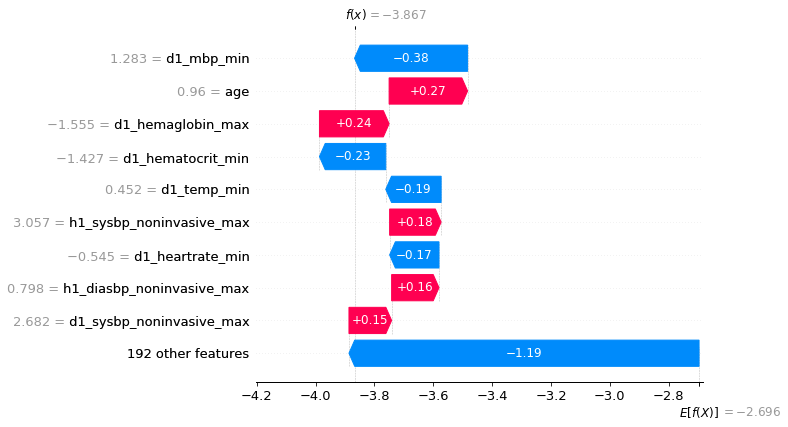

In [28]:
shap.plots.waterfall(shap_female)

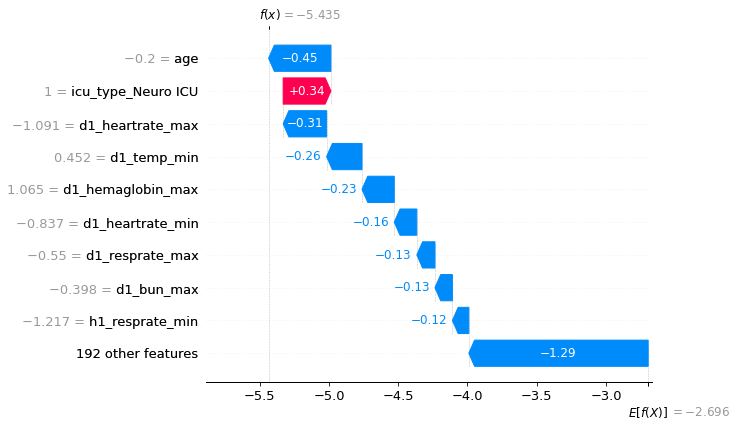

In [29]:
shap.plots.waterfall(shap_younger)

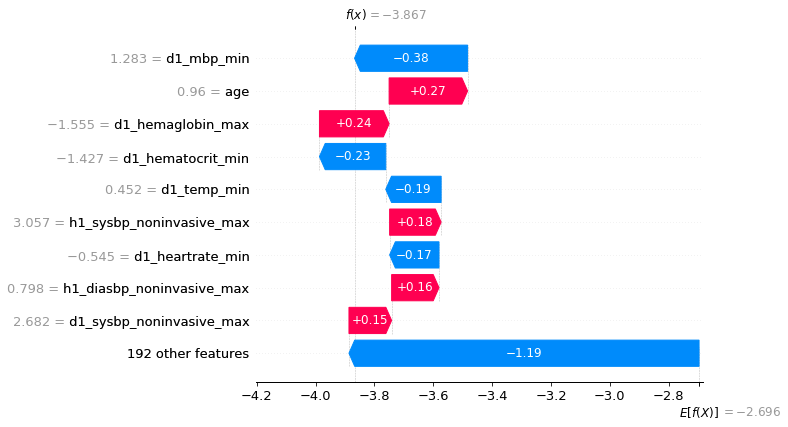

In [30]:
shap.plots.waterfall(shap_older)

(l) Do you notice any discrepancies in the features used by the model to make predictions for the two cohorts in each split? If yes, briefly describe those discrepancies. If not, briefly explain why you think such discrepancies were not observed.

There are some discrepancies, but overall, the predictions seem to be made in the same way.

## Problem 2. Delving into Disparities 

(a) Plot, each on a different pie chart, the distribution of the patients’ genders, ages (bucketed into 5 year intervals), and races. Do you notice any imbalances in the data?

In [34]:
# For proportion in train set
white_X_train, non_white_X_train = len(X_train[X_train["ethnicity_Caucasian"] == 1]), len(X_train[X_train["ethnicity_Caucasian"] != 1])
male_X_train, female_X_train = len(X_train[X_train["gender_M"] == 1]), len(X_train[X_train["gender_F"] == 1])
younger_X_train, older_X_train = len(X_train[(X_train_raw["age"].fillna(X_train_raw["age"].mean()) < 65).to_numpy()]), len(X_train[(X_train_raw["age"].fillna(X_train_raw["age"].mean()) >= 65).to_numpy()])

Train

In [35]:
# Ethnicity train

labels = ["White", "Non white"]
values = [white_X_train, non_white_X_train]

fig = go.Figure(data=[go.Pie(labels=labels, values=values,  textinfo="label+percent")])
fig.update_layout(title_text="Pie chart ethnicity distribution - train")
fig.show()

In [39]:
# Ethnicity test

labels = ["White", "Non white"]
values = [len(white_X), len(non_white_X)]

fig = go.Figure(data=[go.Pie(labels=labels, values=values,  textinfo="label+percent")])
fig.update_layout(title_text="Pie chart ethnicity distribution - test")
fig.show()

In [40]:
# Gender train

labels = ["Male", "Female"]
values = [male_X_train, female_X_train]

fig = go.Figure(data=[go.Pie(labels=labels, values=values,  textinfo="label+percent")])
fig.update_layout(title_text="Pie chart gender distribution - train")
fig.show()

In [41]:
# Gender test

labels = ["Male", "Female"]
values = [len(male_X), len(female_X)]

fig = go.Figure(data=[go.Pie(labels=labels, values=values,  textinfo="label+percent")])
fig.update_layout(title_text="Pie chart gender distribution - test")
fig.show()

In [42]:
# Age train

age_col = X_train_raw["age"].fillna(X_train_raw["age"].mean())
max_age = age_col.max()
boundaries = [(int(i * max_age / 5), int((i+1) * max_age / 5)) for i in range(5)]
values = [len(X_train_raw[(low < age_col) & (age_col <= high)]) for (low, high) in boundaries]
labels = [f"{low} - {high}" for (low, high) in boundaries]

fig = go.Figure(data=[go.Pie(labels=labels, values=values,  textinfo="label+percent")])
fig.update_layout(title_text="Pie chart age distribution - train", legend_title_text="Age between (years):")
fig.show()

In [45]:
# Age test

age_col = X_test_raw["age"].fillna(X_test_raw["age"].mean())
# => use same max_age as train

# max_age = age_col.max()
# boundaries = [(int(i * max_age / 5), int((i+1) * max_age / 5)) for i in range(5)]
values = [len(X_test_raw[(low < age_col) & (age_col <= high)]) for (low, high) in boundaries]
# labels = [f"{low} - {high}" for (low, high) in boundaries]

fig = go.Figure(data=[go.Pie(labels=labels, values=values,  textinfo="label+percent")])
fig.update_layout(title_text="Pie chart age distribution - test", legend_title_text="Age between (years):")
fig.show()

White and olders patients are way more represented in this dataset. Male patients are a little bit more represented in this dataset (54%) compared to female patients (46%).

(b) Follow the instructions in the notebook to reduce the number of training datapoints corresponding to non-white patients by 20%, 40%, 60%, and 80% respectively. For each reduction in the number of datapoints, train an xgboost model on the modified dataset and compute the same performance metrics introduced in part 1 (accuracy, precision, recall, F1 score, and AUC score) on both the modified training set and the original test set. Additionally, compute the same performance metrics on each of the white and non-white cohorts. Report your results in a table.

In [46]:
def drop_rows_criteria(df: pd.DataFrame,
                       outcome: pd.DataFrame,
                       pct_drop: float) -> pd.DataFrame:
    """
    Return two new versions of a dataset and the corresponding outcome
    without some rows based on a certain criteria
    (to change in the code of this function)

    Args:
        df (pd.DataFrame): initial dataset, pandas DataFrame format
        outcome (pd.DataFrame): outcome dataset, pandas DataFrame format
        pct_drop (float): percentage of chance to drop a value
            if a certain criteria is met

    Returns:
        pd.DataFrame: modified dataset
        pd.DataFrame: modified outcome
    
    Example:
        X_train_raw2, y_train2 = drop_rows_criteria(X_train_raw, y_train)
    """
    df2 = df.copy(deep=True).reset_index(drop=True)  # work on a copy of the dataframe
    outcome2 = outcome.copy(deep=True).reset_index(drop=True)
    indices_to_drop = []

    for i in range(len(df2)):
        #########
        # Modify critera for your needs
        if df2.iat[i, df2.columns.get_loc("ethnicity")] != "Caucasian":

            if np.random.random() < pct_drop:  # pct_drop chance to drop this row
                indices_to_drop.append(i)
    df2.drop(indices_to_drop, axis=0, inplace=True)
    outcome2.drop(indices_to_drop, axis=0, inplace=True)
    return df2, outcome2

In [50]:
from tqdm import tqdm

report = {}
percentages = [0.2, 0.4, 0.6, 0.8]
for pct in tqdm(percentages):
    np.random.seed(42)  # set seed
    # drop rows
    X_train_raw2, y_train2 = drop_rows_criteria(X_train_raw, y_train, pct)  # drop train set
    
    # fit preprocessing pipeline on new train set
    preprocessing_pipeline2 = Pipeline(
        steps=[("preprocessing", preprocessing)]
    )
    X_train2 = preprocessing_pipeline2.fit_transform(X_train_raw2)  # fit on train set
    # extract new feature names
    features_names = list(preprocessing_pipeline2[0].transformers_[0][2]) + list(preprocessing_pipeline2[0].transformers_[1][1].get_feature_names_out())
    X_train2 = pd.DataFrame(X_train2, columns=features_names)  # to dataframe type
    X_test2 = pd.DataFrame(preprocessing_pipeline2.transform(X_test_raw), columns=features_names)

    white_X2, non_white_X2, _, _, _, _ = calculate_cohorts(X_test2, X_test_raw)

    # fit model
    xgb.fit(X_train2, y_train2)
    perf_global = evaluate_model(xgb, metrics_dic, X_train2, y_train2, X_test2, y_test)
    perf_global.index = [f"{x}_{pct}" for x in list(perf_global.index)]
    white_metrics = evaluate_model(xgb, metrics_dic, X_train2, y_train2, white_X2, white_y)
    white_metrics.index = [f"{x}_white_{pct}" for x in list(white_metrics.index)]
    non_white_metrics = evaluate_model(xgb, metrics_dic, X_train2, y_train2, non_white_X2, non_white_y)
    non_white_metrics.index = [f"{x}_non_white_{pct}" for x in list(non_white_metrics.index)]
    report[pct] = {"global": perf_global,
                   "white": white_metrics,
                   "non_white": non_white_metrics}

100%|██████████| 4/4 [04:10<00:00, 62.61s/it]


In [51]:
final_table = pd.concat([report[pct]["global"] for pct in percentages] + [report[pct]["white"][1:] for pct in percentages] + [report[pct]["non_white"][1:] for pct in percentages])
final_table

,Accuracy,Precision,Recall,F1-score,AUC Score
Train_0.2,0.968474,0.981887,0.646513,0.779664,0.822694
Test_0.2,0.927275,0.667550,0.317580,0.430401,0.651300
Train_0.4,0.968851,0.984314,0.651384,0.783967,0.825199
Test_0.4,0.926621,0.656697,0.318210,0.428693,0.651227
Train_0.6,0.969383,0.984699,0.657304,0.788363,0.828167
Test_0.6,0.924767,0.636005,0.304978,0.412266,0.644223
Train_0.8,0.971093,0.989890,0.675029,0.802687,0.837185
Test_0.8,0.924985,0.632040,0.318210,0.423303,0.650332
Test_white_0.2,0.927176,0.673250,0.307882,0.422535,0.646863
Test_white_0.4,0.927105,0.667247,0.314450,0.427455,0.649797


(c) How does reducing the number of data points available for some cohorts affect the performance of the model?

In [52]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=2)
fig.add_trace(go.Scatter(x=percentages,
                         y=final_table[-4:]["Accuracy"],
                         mode="lines", name="Accuracy"),
                         row=1, col=1)
fig.add_trace(go.Scatter(x=percentages,
                         y=final_table[-4:]["Precision"],
                         mode="lines", name="Precision"),
                         row=1, col=2)
fig.add_trace(go.Scatter(x=percentages,
                         y=final_table[-4:]["F1-score"],
                         mode="lines", name="F1-score"),
                         row=2, col=1)
fig.add_trace(go.Scatter(x=percentages,
                         y=final_table[-4:]["AUC Score"],
                         mode="lines", name="AUC Score"),
                         row=2, col=2)
fig.update_layout(height=600, width=800, title_text="Performance of the model on the non white patients' test set as a function of<br>the percentage of non white patients missing in the train set",
                  legend_title_text="Metric")
fig.update_xaxes(title_text="Non white patients missing in train set (%)", row=1, col=1)
fig.update_yaxes(title_text="Metric value", row=1, col=1)
fig.show()

The more non white patients we drop, the lower the accuracy and the precision are. It seems to be true also for the F1-score and the AUC Score, with only one small exception.

(d) Repeat part (b) for the male/female split and for the above-and-below-65 age split. Do you notice the same effect on model performance for these splits as you did in part (c)?

In [53]:
def drop_rows_criteria(df: pd.DataFrame,
                       outcome: pd.DataFrame,
                       pct_drop: float) -> pd.DataFrame:
    """
    Return two new versions of a dataset and the corresponding outcome
    without some rows based on a certain criteria
    (to change in the code of this function)

    Args:
        df (pd.DataFrame): initial dataset, pandas DataFrame format
        outcome (pd.DataFrame): outcome dataset, pandas DataFrame format
        pct_drop (float): percentage of chance to drop a value
            if a certain criteria is met

    Returns:
        pd.DataFrame: modified dataset
        pd.DataFrame: modified outcome
    
    Example:
        X_train_raw2, y_train2 = drop_rows_criteria(X_train_raw, y_train)
    """
    df2 = df.copy(deep=True).reset_index(drop=True)  # work on a copy of the dataframe
    outcome2 = outcome.copy(deep=True).reset_index(drop=True)
    indices_to_drop = []

    for i in range(len(df2)):
        #########
        # Modify critera for your needs
        if df2.iat[i, df2.columns.get_loc("gender")] != "M":

            if np.random.random() < pct_drop:  # pct_drop chance to drop this row
                indices_to_drop.append(i)
    df2.drop(indices_to_drop, axis=0, inplace=True)
    outcome2.drop(indices_to_drop, axis=0, inplace=True)
    return df2, outcome2

In [54]:
from tqdm import tqdm

report = {}
percentages = [0.2, 0.4, 0.6, 0.8]
for pct in tqdm(percentages):
    np.random.seed(42)  # set seed
    # drop rows
    X_train_raw2, y_train2 = drop_rows_criteria(X_train_raw, y_train, pct)  # drop train set
    
    # fit preprocessing pipeline on new train set
    preprocessing_pipeline2 = Pipeline(
        steps=[("preprocessing", preprocessing)]
    )
    X_train2 = preprocessing_pipeline2.fit_transform(X_train_raw2)  # fit on train set
    # extract new feature names
    features_names = list(preprocessing_pipeline2[0].transformers_[0][2]) + list(preprocessing_pipeline2[0].transformers_[1][1].get_feature_names_out())
    X_train2 = pd.DataFrame(X_train2, columns=features_names)  # to dataframe type
    X_test2 = pd.DataFrame(preprocessing_pipeline2.transform(X_test_raw), columns=features_names)

    _, _, male_X2, female_X2, _, _ = calculate_cohorts(X_test2, X_test_raw)

    # fit model
    xgb.fit(X_train2, y_train2)
    perf_global = evaluate_model(xgb, metrics_dic, X_train2, y_train2, X_test2, y_test)
    perf_global.index = [f"{x}_{pct}" for x in list(perf_global.index)]
    male_metrics = evaluate_model(xgb, metrics_dic, X_train2, y_train2, male_X2, male_y)
    male_metrics.index = [f"{x}_male_{pct}" for x in list(male_metrics.index)]
    female_metrics = evaluate_model(xgb, metrics_dic, X_train2, y_train2, female_X2, female_y)
    female_metrics.index = [f"{x}_female_{pct}" for x in list(female_metrics.index)]
    report[pct] = {"global": perf_global,
                   "male": male_metrics,
                   "female": female_metrics}

100%|██████████| 4/4 [02:40<00:00, 40.06s/it]


In [55]:
final_table = pd.concat([report[pct]["global"] for pct in percentages] + [report[pct]["male"][1:] for pct in percentages] + [report[pct]["female"][1:] for pct in percentages])
final_table

,Accuracy,Precision,Recall,F1-score,AUC Score
Train_0.2,0.968414,0.982280,0.645688,0.779188,0.822294
Test_0.2,0.925748,0.648221,0.310019,0.419437,0.647042
Train_0.4,0.970984,0.989401,0.670159,0.799075,0.834741
Test_0.4,0.925639,0.645372,0.311909,0.420561,0.647838
Train_0.6,0.974175,0.987361,0.706596,0.823711,0.852876
Test_0.6,0.925203,0.635561,0.317580,0.423529,0.650166
Train_0.8,0.977732,0.992860,0.743003,0.849949,0.871253
Test_0.8,0.925149,0.638961,0.310019,0.417480,0.646714
Test_male_0.2,0.928377,0.663391,0.320665,0.432346,0.652769
Test_male_0.4,0.927164,0.645783,0.318290,0.426412,0.651030


In [56]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=2)
fig.add_trace(go.Scatter(x=percentages,
                         y=final_table[-4:]["Accuracy"],
                         mode="lines", name="Accuracy"),
                         row=1, col=1)
fig.add_trace(go.Scatter(x=percentages,
                         y=final_table[-4:]["Precision"],
                         mode="lines", name="Precision"),
                         row=1, col=2)
fig.add_trace(go.Scatter(x=percentages,
                         y=final_table[-4:]["F1-score"],
                         mode="lines", name="F1-score"),
                         row=2, col=1)
fig.add_trace(go.Scatter(x=percentages,
                         y=final_table[-4:]["AUC Score"],
                         mode="lines", name="AUC Score"),
                         row=2, col=2)
fig.update_layout(height=600, width=800, title_text="Performance of the model on the female patients' test set as a function of<br>the percentage of female patients missing in the train set",
                  legend_title_text="Metric")
fig.update_xaxes(title_text="Female patients missing in train set (%)", row=1, col=1)
fig.update_yaxes(title_text="Metric value", row=1, col=1)
fig.show()

The results are not conclusive for female patients.

In [76]:
import math
def drop_rows_criteria(df: pd.DataFrame,
                       outcome: pd.DataFrame,
                       pct_drop: float) -> pd.DataFrame:
    """
    Return two new versions of a dataset and the corresponding outcome
    without some rows based on a certain criteria
    (to change in the code of this function)

    Args:
        df (pd.DataFrame): initial dataset, pandas DataFrame format
        outcome (pd.DataFrame): outcome dataset, pandas DataFrame format
        pct_drop (float): percentage of chance to drop a value
            if a certain criteria is met

    Returns:
        pd.DataFrame: modified dataset
        pd.DataFrame: modified outcome
    
    Example:
        X_train_raw2, y_train2 = drop_rows_criteria(X_train_raw, y_train)
    """
    df2 = df.copy(deep=True).reset_index(drop=True)  # work on a copy of the dataframe
    outcome2 = outcome.copy(deep=True).reset_index(drop=True)
    indices_to_drop = []

    for i in range(len(df2)):
        #########
        # Modify critera for your needs
        if not(math.isnan(df2.iat[i, df2.columns.get_loc("age")])) and (df2.iat[i, df2.columns.get_loc("age")] >= 65):

            if np.random.random() < pct_drop:  # pct_drop chance to drop this row
                indices_to_drop.append(i)
    df2.drop(indices_to_drop, axis=0, inplace=True)
    outcome2.drop(indices_to_drop, axis=0, inplace=True)
    return df2, outcome2

In [77]:
from tqdm import tqdm

report = {}
percentages = [0.2, 0.4, 0.6, 0.8]
for pct in tqdm(percentages):
    np.random.seed(42)  # set seed
    # drop rows
    X_train_raw2, y_train2 = drop_rows_criteria(X_train_raw, y_train, pct)  # drop train set
    
    # fit preprocessing pipeline on new train set
    preprocessing_pipeline2 = Pipeline(
        steps=[("preprocessing", preprocessing)]
    )
    X_train2 = preprocessing_pipeline2.fit_transform(X_train_raw2)  # fit on train set
    # extract new feature names
    features_names = list(preprocessing_pipeline2[0].transformers_[0][2]) + list(preprocessing_pipeline2[0].transformers_[1][1].get_feature_names_out())
    X_train2 = pd.DataFrame(X_train2, columns=features_names)  # to dataframe type
    X_test2 = pd.DataFrame(preprocessing_pipeline2.transform(X_test_raw), columns=features_names)

    _, _, _, _, younger_X2, older_X2 = calculate_cohorts(X_test2, X_test_raw)

    # fit model
    xgb.fit(X_train2, y_train2)
    perf_global = evaluate_model(xgb, metrics_dic, X_train2, y_train2, X_test2, y_test)
    perf_global.index = [f"{x}_{pct}" for x in list(perf_global.index)]
    younger_metrics = evaluate_model(xgb, metrics_dic, X_train2, y_train2, younger_X2, younger_y)
    younger_metrics.index = [f"{x}_younger_{pct}" for x in list(younger_metrics.index)]
    older_metrics = evaluate_model(xgb, metrics_dic, X_train2, y_train2, older_X2, older_y)
    older_metrics.index = [f"{x}_older_{pct}" for x in list(older_metrics.index)]
    report[pct] = {"global": perf_global,
                   "younger": younger_metrics,
                   "older": older_metrics}

100%|██████████| 4/4 [02:50<00:00, 42.66s/it]


In [78]:
final_table = pd.concat([report[pct]["global"] for pct in percentages] + [report[pct]["younger"][1:] for pct in percentages] + [report[pct]["older"][1:] for pct in percentages])
final_table

,Accuracy,Precision,Recall,F1-score,AUC Score
Train_0.2,0.970308,0.984157,0.657163,0.788087,0.828097
Test_0.2,0.928256,0.676662,0.327032,0.440952,0.656116
Train_0.4,0.974568,0.989040,0.694035,0.815683,0.846678
Test_0.4,0.926293,0.653194,0.315690,0.425658,0.649908
Train_0.6,0.979518,0.994322,0.738526,0.847544,0.869087
Test_0.6,0.927438,0.667102,0.321991,0.434339,0.653386
Train_0.8,0.985033,0.997329,0.795981,0.885351,0.897907
Test_0.8,0.927438,0.672973,0.313800,0.428019,0.649679
Test_younger_0.2,0.946679,0.685185,0.355200,0.467861,0.671835
Test_younger_0.4,0.943617,0.643533,0.326400,0.433121,0.656813


In [79]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=2)
fig.add_trace(go.Scatter(x=percentages,
                         y=final_table[-4:]["Accuracy"],
                         mode="lines", name="Accuracy"),
                         row=1, col=1)
fig.add_trace(go.Scatter(x=percentages,
                         y=final_table[-4:]["Precision"],
                         mode="lines", name="Precision"),
                         row=1, col=2)
fig.add_trace(go.Scatter(x=percentages,
                         y=final_table[-4:]["F1-score"],
                         mode="lines", name="F1-score"),
                         row=2, col=1)
fig.add_trace(go.Scatter(x=percentages,
                         y=final_table[-4:]["AUC Score"],
                         mode="lines", name="AUC Score"),
                         row=2, col=2)
fig.update_layout(height=600, width=800, title_text="Performance of the model on the older patients' test set as a function of<br>the percentage of older patients missing in the train set",
                  legend_title_text="Metric")
fig.update_xaxes(title_text="Older patients missing in train set (%)", row=1, col=1)
fig.update_yaxes(title_text="Metric value", row=1, col=1)
fig.show()

Again, our assumption is verified here for older people.

(e) Follow the instructions in the notebook to retrain the model on the above splits/datapoint drop percentages but weighing the datapoints differently based on cohort imbalances this time. How does your new model’s performance compare to its previous performance?


In [74]:
from sklearn.utils.class_weight import compute_sample_weight

preprocessing_pipeline2 = Pipeline(
    steps=[("preprocessing", preprocessing)]
)
X_train2 = preprocessing_pipeline2.fit_transform(X_train_raw)  # fit on train set
# extract new feature names
features_names = list(preprocessing_pipeline2[0].transformers_[0][2]) + list(preprocessing_pipeline2[0].transformers_[1][1].get_feature_names_out())
X_train2 = pd.DataFrame(X_train2, columns=features_names)  # to dataframe type
X_test2 = pd.DataFrame(preprocessing_pipeline.transform(X_test_raw), columns=features_names)

# white_X, non_white_X, male_X, female_X, younger_X, older_X = calculate_cohorts(X_test, X_test_raw)

# fit model
sample_weight = compute_sample_weight("balanced", y_train)
xgb.fit(X_train2, y_train, sample_weight=sample_weight)
# evaluate model with sample weights used on train set only
perf_global = evaluate_model(xgb, metrics_dic, X_train2, y_train, X_test2, y_test, sample_weight=sample_weight)
perf_global.index = [f"{x}_{pct}" for x in list(perf_global.index)]
perf_global

,Accuracy,Precision,Recall,F1-score,AUC Score
Train_0.8,0.932684,0.923846,0.943110,0.933378,0.932684
Test_0.8,0.871177,0.363284,0.649653,0.465989,0.770906


On the test set, the accuracy is lower than question 1)e) but the F1-score and the AUC Score are better (especially for the AUC Score).

(f) Follow the instructions in the notebook to vary the "missingness" in the train set of non-white patients (by 20%, 40%, 60%, and 80%). Train an xgboost model on the modified dataset and compute the same performance metrics introduced in part 1 (accuracy, precision, recall, F1 score, and AUC score) on both the modified training set and the original test set. Additionally, compute the same performance metrics on each of the white and non-white cohorts. Report your results in a table.

In [80]:
def add_missingness_criteria(df: pd.DataFrame,
                             pct_missing: float) -> pd.DataFrame:
    """
    Return a new version of the dataset with some artificial NaN values based on a
    certain criteria (to change in the code of this function)

    Args:
        df (pd.DataFrame): initial dataset, pandas DataFrame format
        pct_missing (float): percentage of missing values that we
            introduce for a specific subgroup of the population

    Returns:
        pd.DataFrame: modified dataset
    """
    df2 = df.copy(deep=True)  # work on a copy of the dataframe
    # modifiy only numerical features to avoid nan in categorical features
    # otherwise, the onehotencoder may add new features
    numerical_features = [c for c in df2.columns if df2[c].dtype.name == "float64"]
    for i in range(len(df2)):
        #########
        # Modify critera for your needs
        if df2.iat[i, df2.columns.get_loc("ethnicity")] != "Caucasian":

            for feat in numerical_features:
                if np.random.random() < pct_missing:  # pct_missing chance to replace by a NaN
                    df2.iat[i, df2.columns.get_loc(feat)] = np.nan
    return df2

In [81]:
from tqdm import tqdm

report = {}
percentages = [0.2, 0.4, 0.6, 0.8]
for pct in tqdm(percentages):
    np.random.seed(42)  # set seed
    # drop rows
    y_train2 = y_train
    X_train_raw2 = add_missingness_criteria(X_train_raw, pct)  # add missing train set
    
    # fit preprocessing pipeline on new train set
    preprocessing_pipeline2 = Pipeline(
        steps=[("preprocessing", preprocessing)]
    )
    X_train2 = preprocessing_pipeline2.fit_transform(X_train_raw2)  # fit on train set
    # extract new feature names
    features_names = list(preprocessing_pipeline2[0].transformers_[0][2]) + list(preprocessing_pipeline2[0].transformers_[1][1].get_feature_names_out())
    X_train2 = pd.DataFrame(X_train2, columns=features_names)  # to dataframe type
    X_test2 = pd.DataFrame(preprocessing_pipeline2.transform(X_test_raw), columns=features_names)

    white_X2, non_white_X2, male_X2, female_X2, younger_X2, older_X2 = calculate_cohorts(X_test2, X_test_raw)

    # fit model
    xgb.fit(X_train2, y_train)
    perf_global = evaluate_model(xgb, metrics_dic, X_train2, y_train, X_test2, y_test)
    perf_global.index = [f"{x}_{pct}" for x in list(perf_global.index)]
    white_metrics = evaluate_model(xgb, metrics_dic, X_train2, y_train, white_X2, white_y)
    white_metrics.index = [f"{x}_white_{pct}" for x in list(white_metrics.index)]
    non_white_metrics = evaluate_model(xgb, metrics_dic, X_train2, y_train, non_white_X2, non_white_y)
    non_white_metrics.index = [f"{x}_non_white_{pct}" for x in list(non_white_metrics.index)]
    report[pct] = {"global": perf_global,
                   "white": white_metrics,
                   "non_white": non_white_metrics}

100%|██████████| 4/4 [24:54<00:00, 373.52s/it]


In [82]:
final_table = pd.concat([report[pct]["global"] for pct in percentages] + [report[pct]["white"][1:] for pct in percentages] + [report[pct]["non_white"][1:] for pct in percentages])
final_table

,Accuracy,Precision,Recall,F1-score,AUC Score
Train_0.2,0.966403,0.981551,0.622155,0.761582,0.810526
Test_0.2,0.926511,0.646626,0.332073,0.438801,0.657443
Train_0.4,0.965490,0.974263,0.616150,0.754889,0.807307
Test_0.4,0.924821,0.622066,0.333963,0.434604,0.657373
Train_0.6,0.964427,0.981357,0.598925,0.743867,0.798926
Test_0.6,0.926184,0.640531,0.334594,0.439570,0.658404
Train_0.8,0.960406,0.977406,0.553729,0.706950,0.776261
Test_0.8,0.922804,0.595960,0.334594,0.428571,0.656554
Test_white_0.2,0.927318,0.662771,0.325944,0.436984,0.655116
Test_white_0.4,0.926394,0.650662,0.322660,0.431394,0.653124


(g) How does increasing the missingness of some test results affect the performance of your model?

In [83]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=2)
fig.add_trace(go.Scatter(x=percentages,
                         y=final_table[-4:]["Accuracy"],
                         mode="lines", name="Accuracy"),
                         row=1, col=1)
fig.add_trace(go.Scatter(x=percentages,
                         y=final_table[-4:]["Precision"],
                         mode="lines", name="Precision"),
                         row=1, col=2)
fig.add_trace(go.Scatter(x=percentages,
                         y=final_table[-4:]["F1-score"],
                         mode="lines", name="F1-score"),
                         row=2, col=1)
fig.add_trace(go.Scatter(x=percentages,
                         y=final_table[-4:]["AUC Score"],
                         mode="lines", name="AUC Score"),
                         row=2, col=2)
fig.update_layout(height=600, width=800, title_text="Performance of the model on the non white patients' test set as a function of<br>the percentage of missing values for non white patients in the train set",
                  legend_title_text="Metric")
fig.update_xaxes(title_text="Missing values for non white patients in train set (%)", row=1, col=1)
fig.update_yaxes(title_text="Metric value", row=1, col=1)
fig.show()

Increasing the missingness of non white patients in the training dataset hardly change the performance (it even seems to increase the AUC Score).

(h) Why do you think increasing the missingness affected performance in the way that it did? (To come up with a good explanation, it might be useful to consider your answers to the previous questions in this problem set as well).


In [89]:
print(f"Average number of missing value in the raw training dataset: {round(100 * X_train_raw.isnull().sum().mean() / len(X_train_raw), 2)}%")

Average number of missing value in the raw training dataset: 37.45%


On average, there is already 37.45% of missing data in the training dataset. Therefore, increasing the number of missing values in non white patients (they only represent 23% of the dataset) doesn't change the global number of missing values a lot. That is why it doesn't really change the performance of the model.

(i) Suggest one potential way of handling missingness of test results.

Using other imputation techniques like MICE might provide better results.